In [1]:
from networks.models import build_model
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class Args:
    encoder = 'resnet50_GN_WS'
    decoder = 'fba_decoder'
    weights = 'FBA.pth'
args=Args()
try:
    model = build_model(args)
except:
    !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
    model = build_model(args)

modifying input layer to accept 11 channels


In [6]:
image = cv2.imread('image.png')

model_trimap = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model_trimap.eval()

input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])


input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model_trimap(input_batch)['out'][0]
    output = torch.softmax(output, 0)
    
output_cat = output[CLASS_MAP['person'], ...].numpy()

trimap_image = trimap(output_cat, 2, 0.95)

Using cache found in C:\Users\Saad.LAKES/.cache\torch\hub\pytorch_vision_v0.6.0


In [39]:
cv2.imwrite('hello.jpg',trimap_image)

True

In [3]:
def read_image(name):
    return (cv2.imread(name) / 255.0)[:, :, ::-1]

def read_trimap(name):
    trimap_im = cv2.imread(name, 0) / 255.0
    h, w = trimap_im.shape
    trimap = np.zeros((h, w, 2))
    trimap[trimap_im == 1, 1] = 1
    trimap[trimap_im == 0, 0] = 1
    return trimap

In [4]:
trimap = read_trimap('trimaps/troll.png')
image = read_image('images/troll.png')

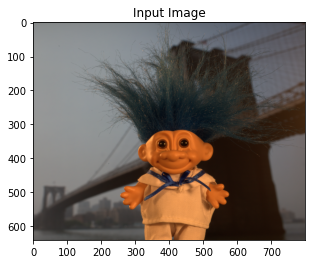

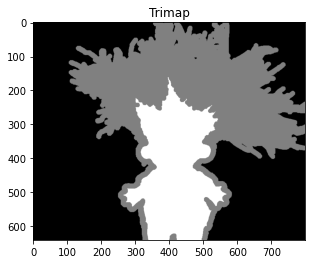

In [5]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
def dt(a):
    return cv2.distanceTransform((a * 255).astype(np.uint8), cv2.DIST_L2, 0)


def trimap_transform(trimap):
    h, w = trimap.shape[0], trimap.shape[1]

    clicks = np.zeros((h, w, 6))
    for k in range(2):
        if(np.count_nonzero(trimap[:, :, k]) > 0):
            dt_mask = -dt(1 - trimap[:, :, k])**2
            L = 320
            clicks[:, :, 3*k] = np.exp(dt_mask / (2 * ((0.02 * L)**2)))
            clicks[:, :, 3*k+1] = np.exp(dt_mask / (2 * ((0.08 * L)**2)))
            clicks[:, :, 3*k+2] = np.exp(dt_mask / (2 * ((0.16 * L)**2)))

    return clicks


# For RGB !
group_norm_std = [0.229, 0.224, 0.225]
group_norm_mean = [0.485, 0.456, 0.406]


def groupnorm_normalise_image(img, format='nhwc'):
    '''
        Accept rgb in range 0,1
    '''
    if(format == 'nhwc'):
        for i in range(3):
            img[..., i] = (img[..., i] - group_norm_mean[i]) / group_norm_std[i]
    else:
        for i in range(3):
            img[..., i, :, :] = (img[..., i, :, :] - group_norm_mean[i]) / group_norm_std[i]

    return img


def groupnorm_denormalise_image(img, format='nhwc'):
    '''
        Accept rgb, normalised, return in range 0,1
    '''
    if(format == 'nhwc'):
        for i in range(3):
            img[:, :, :, i] = img[:, :, :, i] * group_norm_std[i] + group_norm_mean[i]
    else:
        img1 = torch.zeros_like(img).cuda()
        for i in range(3):
            img1[:, i, :, :] = img[:, i, :, :] * group_norm_std[i] + group_norm_mean[i]
        return img1
    return img
def np_to_torch(x):
    return torch.from_numpy(x).permute(2, 0, 1)[None, :, :, :].float().cuda()


def scale_input(x: np.ndarray, scale: float, scale_type) -> np.ndarray:
    ''' Scales inputs to multiple of 8. '''
    h, w = x.shape[:2]
    h1 = int(np.ceil(scale * h / 8) * 8)
    w1 = int(np.ceil(scale * w / 8) * 8)
    x_scale = cv2.resize(x, (w1, h1), interpolation=scale_type)
    return x_scale


def predict_fba_folder(model, args):
    save_dir = args.output_dir

    dataset_test = PredDataset(args.image_dir, args.trimap_dir)

    gen = iter(dataset_test)
    for item_dict in gen:
        image_np = item_dict['image']
        trimap_np = item_dict['trimap']

        fg, bg, alpha = pred(image_np, trimap_np, model)

        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_fg.png'), fg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_bg.png'), bg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_alpha.png'), alpha * 255)


def pred(image_np: np.ndarray, trimap_np: np.ndarray, model) -> np.ndarray:
    ''' Predict alpha, foreground and background.
        Parameters:
        image_np -- the image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        trimap_np -- two channel trimap, first background then foreground. Dimensions: (h, w, 2)
        Returns:
        fg: foreground image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        bg: background image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        alpha: alpha matte image between 0 and 1. Dimensions: (h, w)
    '''
    h, w = trimap_np.shape[:2]

    image_scale_np = scale_input(image_np, 1.0, cv2.INTER_LANCZOS4)
    trimap_scale_np = scale_input(trimap_np, 1.0, cv2.INTER_LANCZOS4)

    with torch.no_grad():

        image_torch = np_to_torch(image_scale_np)
        trimap_torch = np_to_torch(trimap_scale_np)

        trimap_transformed_torch = np_to_torch(trimap_transform(trimap_scale_np))
        image_transformed_torch = groupnorm_normalise_image(image_torch.clone(), format='nchw')

        output = model(image_torch, trimap_torch, image_transformed_torch, trimap_transformed_torch)

        output = cv2.resize(output[0].cpu().numpy().transpose((1, 2, 0)), (w, h), cv2.INTER_LANCZOS4)
    alpha = output[:, :, 0]
    fg = output[:, :, 1:4]
    bg = output[:, :, 4:7]

    alpha[trimap_np[:, :, 0] == 1] = 0
    alpha[trimap_np[:, :, 1] == 1] = 1
    fg[alpha == 1] = image_np[alpha == 1]
    bg[alpha == 0] = image_np[alpha == 0]
    return fg, bg, alpha


In [11]:
fg, bg, alpha = pred(image, trimap, model)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [50]:
t.shape

(424, 600, 2)

In [51]:
image.shape

(424, 600, 3)

In [5]:
import os
import argparse
import torch
import numpy as np
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

IMG_EXT = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')

CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}


def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake



# def main(input_dir, target_class, show, conf_threshold):
    


# if __name__ == "__main__":
#     args = parse_args()
#     main(args.input_dir, args.target_class, args.show, args.conf_threshold)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

image = cv2.imread('image.PNG')
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


input_tensor = preprocess(input_image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
print('last',input_batch.shape)

with torch.no_grad():
    output = model(input_batch)['out'][0]
    output = torch.softmax(output, 0)
    
output_cat = output[CLASS_MAP['person'], ...].numpy()

trimap_image = trimap(output_cat, 2, 0.95)

#     trimaps_path = os.path.join(input_dir, "trimaps")
#     os.makedirs(trimaps_path, exist_ok=True)

#     images_list = os.listdir(input_dir)
#     for filename in images_list:
#         if not filename.endswith(IMG_EXT):
#             continue
#         input_image = cv2.imread(os.path.join(input_dir, filename))
#         original_image = input_image.copy()

#         input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

#         preprocess = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

#         input_tensor = preprocess(input_image)
#         input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

#         with torch.no_grad():
#             output = model(input_batch)['out'][0]
#             output = torch.softmax(output, 0)

#         output_cat = output[CLASS_MAP[target_class], ...].numpy()

#         trimap_image = trimap(output_cat, 7, conf_threshold)
#         trimap_filename = os.path.basename(filename).split('.')[0] + '.png'
#         cv2.imwrite(os.path.join(trimaps_path, trimap_filename), trimap_image)

#         if show:
#             cv2.imshow('mask', output_cat)
#             cv2.imshow('image', original_image)
#             cv2.imshow('trimap', trimap_image)
#             cv2.waitKey(0)

In [ ]:
output_cat.shape

In [ ]:
plt.imshow(trimap_image)

In [ ]:
np.unique(trimap_image)

In [ ]:
foo = cv2.imread('background7.jpg')
foo = cv2.resize(foo,(600,424))
foo[trimap_image!=0]=0
plt.imshow(foo)

In [ ]:
img = image
img[trimap_image==0]=0
plt.imshow(img)

In [ ]:
plt.imshow(foo+img)

In [ ]:
cv2.imread('boy.png')

In [ ]:
cv2.imwrite('hello.jpg',trimap_image)

In [ ]:
x=cv2.imread('hello.jpg')

In [ ]:
x1=x[:,:,0]
x2=x[:,:,1]
x3=x[:,:,2]


In [ ]:
x3.shape

In [ ]:
np.unique(x2-x3)

In [ ]:
s=np.arange(20)

In [ ]:
s[::-1]

In [ ]:
def swap_bg(image, alpha):
    green_bg = np.zeros_like(image).astype(np.float32)
    green_bg[:, :, 1] = 255

    alpha = alpha[:, :, np.newaxis]
    result = alpha * image.astype(np.float32) + (1 - alpha) * green_bg
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

In [ ]:
s = swap_bg(image1,trimap_image)

In [ ]:
image1 = cv2.imread('image.PNG')

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(x)

In [ ]:
x.shape

In [ ]:
def dt(a):
    return cv2.distanceTransform((a * 255).astype(np.uint8), cv2.DIST_L2, 0)

def trimap_transform(trimap):
    h, w = trimap.shape[0], trimap.shape[1]

    clicks = np.zeros((h, w, 6))
    for k in range(2):
        if np.count_nonzero(trimap[:, :, k]) > 0:
            dt_mask = -dt(1 - trimap[:, :, k]) ** 2
            L = 320
            clicks[:, :, 3 * k] = np.exp(dt_mask / (2 * ((0.02 * L) ** 2)))
            clicks[:, :, 3 * k + 1] = np.exp(dt_mask / (2 * ((0.08 * L) ** 2)))
            clicks[:, :, 3 * k + 2] = np.exp(dt_mask / (2 * ((0.16 * L) ** 2)))

    return clicks

In [ ]:
y = trimap_transform(x[:,:,:2])

In [ ]:
y.shape